In [1]:
import torch
from torch import nn

import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange

import model
from data import seq_data, grid_data
from visualization import hidden_repr
from preprocessing import OneHot

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [2]:
## Instantiate model
model = model.Model(
    encoding=None,
    input_size=2,
    output_size=2,
    hidden_dim=10,
    n_layers=4,
    device=device,
    init_std=0.01,
    # output_noise=0.05,
)

In [3]:
## Generate data
symbols = {0, 1}
encoding = OneHot(symbols)
xor_problem = lambda seq: np.sum(seq) % 2
par_3_problem = lambda seq: int(np.sum(seq) % 3 == 2)
problem = par_3_problem

train_datasets = [
    seq_data(device, problem, encoding, seq_len=1),
    seq_data(device, problem, encoding, seq_len=2),
    seq_data(device, problem, encoding, seq_len=3),
    # seq_data(device, problem, encoding, seq_len=4),
    # seq_data(device, problem, encoding, seq_len=5),
]

val_datasets = [
    seq_data(device, problem, encoding, n_datapoints=10, seq_len=10),
    seq_data(device, problem, encoding, seq_len=1),
    seq_data(device, problem, encoding, seq_len=2),
    seq_data(device, problem, encoding, seq_len=3),
    # seq_data(device, problem, encoding, seq_len=4),
    # seq_data(device, problem, encoding, seq_len=5),
]

grid = grid_data(device, dim=2, output_dim=2, n=20, bounds=(-1, 1))

model.encoding = encoding

In [4]:
## Train

# Define hyperparameters
n_epochs = 20000
lr = 0.005

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training run
(
    train_losses,
    val_losses,
    hidden_states,
    output_values,
    # grid_hiddens,
    # grid_outputs,
) = model.training_run(
    optimizer,
    criterion,
    train_datasets,
    val_datasets,
    # grid,
    n_epochs=n_epochs,
    batch_size=1000,
)

Training: 100%|██████████| 10000/10000 [03:11<00:00, 52.16steps/s, train_loss=0.06251, val_loss=0.47456]


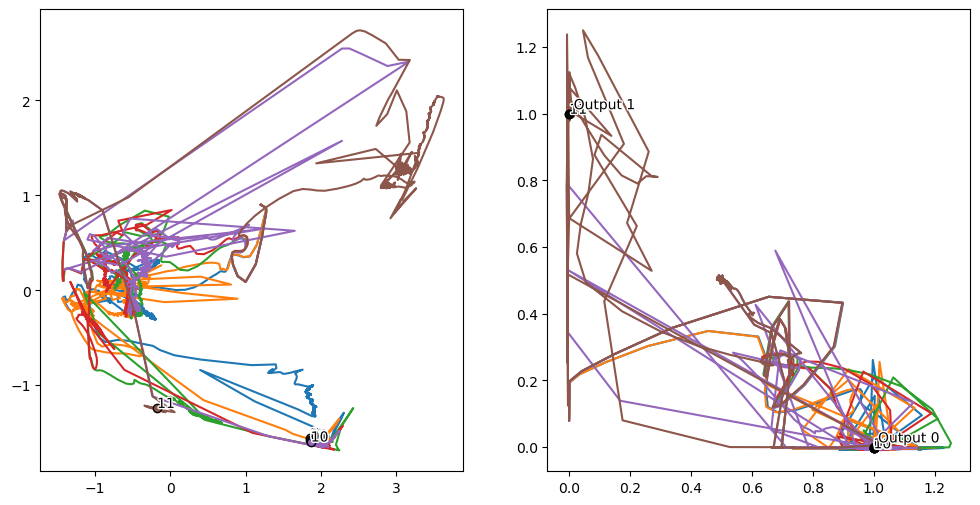

interactive(children=(IntSlider(value=0, description='Epoch:', layout=Layout(width='42%'), max=9999), Output()…

In [5]:
import pandas as pd

## Show evolution of hidden states
query = "Epoch >= 0"
query += "and (Dataset > 0)"
query += "and (Dataset != 3)"
data_hid = hidden_states.query(query).copy()
data_output = output_values.query(query).copy()

hidden_repr(
    data_hid,
    data_output,
    transform=("PCA", "none"),
    n_labels=0,
    fig_size=6,
    encoding=encoding,
    plot_labels=True,
)
# TODO Plot map A(h)
# TODO Plot pairwise distances

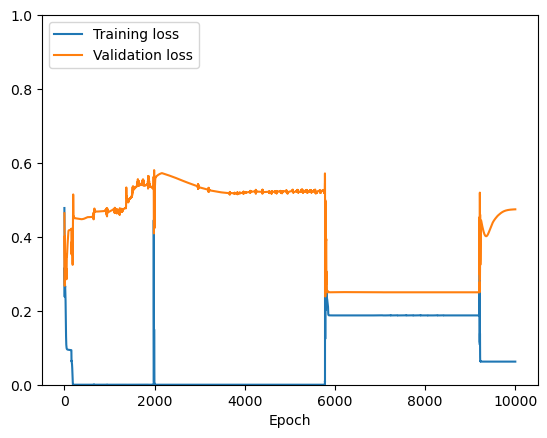

In [6]:
## Plot training and validation loss during training
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses[:, 0], label="Validation loss")
plt.legend(loc="upper left")
plt.xlabel("Epoch")
plt.ylim(0, 1)
plt.show()

100%|██████████| 100/100 [00:00<00:00, 119.43it/s]


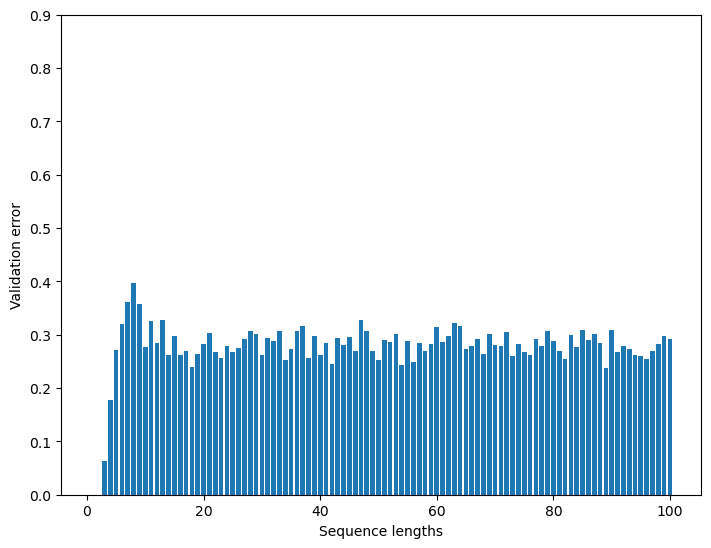

In [7]:
## Plot error per sequence length
N = 100
val_data = []
for n in trange(1, N + 1):
    val_data.append(seq_data(device, problem, encoding, n_datapoints=100, seq_len=n))
val_err = np.array(model.validation(criterion, val_data))

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(np.arange(1, N + 1), val_err)
ax.set_xlabel("Sequence lengths")
ax.set_ylabel("Validation error")
ax.set_yticks(np.arange(0, 1, 0.1))
plt.show()

In [8]:
def predict(model, sequence):
    input = torch.from_numpy(np.array([encoding(sequence)], dtype=np.float32)).to(
        device
    )
    out, hidden = model(input)
    prediction = out.cpu().detach().numpy()
    return prediction


x = [0, 0, 0, 1, 0, 0, 0]
print(f"Prediction: {predict(model, x)}, True output: {problem(x)}")

Prediction: [[ 0.999485   -0.00373224]], True output: 0
